In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_lr_bnn import MFDNNBNN
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfbml.methods.mf_dnn_bnn import SequentialMFBNN

from mfbml.metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.gaussian_process import GaussianProcessRegression
# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# read the data
data = pd.read_pickle("data.pkl")

In [6]:
# single fidelity model
sf_gpr = GaussianProcessRegression(
    design_space=np.array([[0, 1]]),
    noise_prior=0.05,
    optimizer_restart=20,)
sf_gpr.train(X=hf_samples.numpy(), Y=hf_responses.numpy())

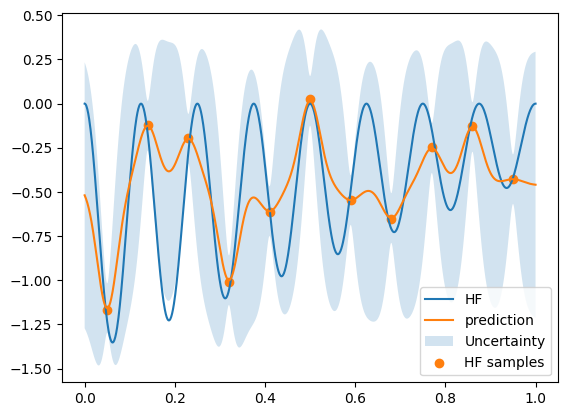

In [7]:
# get the predictions
sf_gpr_predictions, sf_gpr_std = sf_gpr.predict(
    test_samples.numpy(), return_std=True)
# plot
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")

ax.plot(test_samples, sf_gpr_predictions, label="prediction")
ax.fill_between(test_samples.flatten(), (sf_gpr_predictions - 2*sf_gpr_std).flatten(),
                (sf_gpr_predictions + 2*sf_gpr_std).flatten(), alpha=0.2, label="Uncertainty")
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")

plt.legend()
plt.show()

In [8]:
# hierarchical kriging to train the model
gpr = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    noise_prior=0.05,)
# train the model
gpr.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
          responses=[hf_responses.numpy(), lf1_responses.numpy(),])
# predict the responses

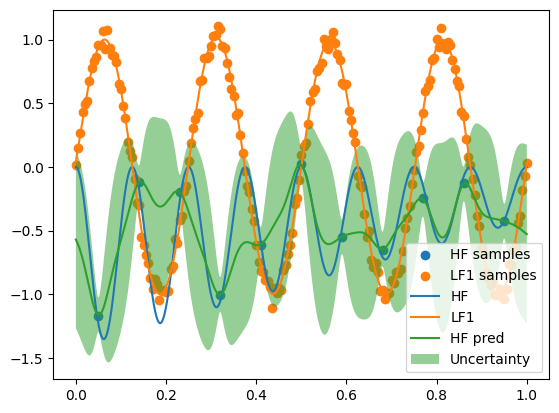

In [9]:
# get the prediction
hf_pred, hf_pred_var = gpr.predict(test_samples.numpy(), return_std=True)
lf1_pred = gpr.predict_lf(test_samples.numpy())
# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, label="LF1 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf1_pred, label="LF1")
ax.plot(test_samples, hf_pred, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred - 2*hf_pred_var).flatten(),
                (hf_pred + 2*hf_pred_var).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

In [10]:
# gpr for lf2
gpr2 = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    noise_prior=None,)
# train the model
gpr2.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
           responses=[hf_responses.numpy(), lf2_responses.numpy(),])
# predict the responses

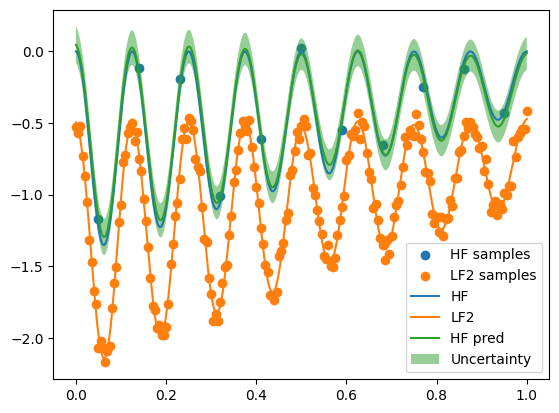

In [11]:
# get the prediction
hf_pred2, hf_pred_var2 = gpr2.predict(test_samples.numpy(), return_std=True)
lf2_pred = gpr2.predict_lf(test_samples.numpy())
# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf2_responses, label="LF2 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf2_pred, label="LF2")
ax.plot(test_samples, hf_pred2, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred2 - 2*hf_pred_var2).flatten(),
                (hf_pred2 + 2*hf_pred_var2).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

In [12]:
# gpr for lf3
gpr3 = HierarchicalKriging(
    design_space=np.array([[0, 1]]),
    noise_prior=0.05,)
# train the model
gpr3.train(samples=[hf_samples.numpy(), lf_samples.numpy()],
           responses=[hf_responses.numpy(), lf3_responses.numpy(),])
# predict the responses

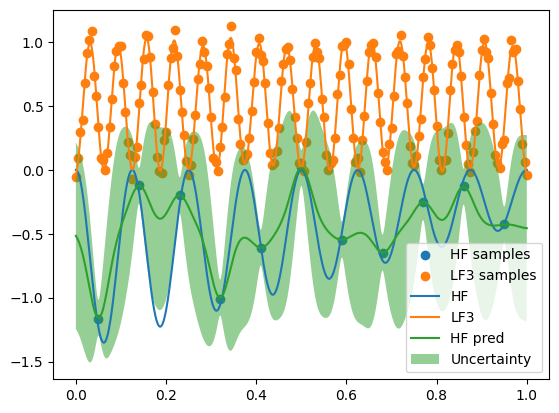

In [13]:
# get the prediction
hf_pred3, hf_pred_var3 = gpr3.predict(test_samples.numpy(), return_std=True)
lf3_pred = gpr3.predict_lf(test_samples.numpy())

# plot the prediction
fig, ax = plt.subplots()
# plot samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf3_responses, label="LF3 samples")
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, lf3_pred, label="LF3")
ax.plot(test_samples, hf_pred3, label="HF pred")
# get the uncertainty
ax.fill_between(test_samples.numpy().flatten(), (hf_pred3 - 2*hf_pred_var3).flatten(),
                (hf_pred3 + 2*hf_pred_var3).flatten(), alpha=0.5, label="Uncertainty")

plt.legend()
plt.show()

In [14]:
gpr3.beta

array([[0.00764311]])

## Configurations for DNN and BNNs


In [15]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 30000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 20000,
}

### train standard BNN using HF data


In [16]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[500, 500],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    x=hf_samples,
    y=hf_responses_scaled,
    num_epochs=30000,
    sample_freq=100,
    burn_in_epochs=20000,
)

/home/yaga/Documents/mfbml/src/mfbml/inference/psgld.py:93: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     0/30000
nll_loss: 284.000, prior_loss: 231829.719, total: 232113.719
noise: 0.131
epoch:   100/30000
nll_loss: 235.918, prior_loss: 266554.938, total: 266790.844
noise: 0.131
epoch:   200/30000
nll_loss: 216.971, prior_loss: 278409.469, total: 278626.438
noise: 0.131
epoch:   300/30000
nll_loss: 250.254, prior_loss: 288005.469, total: 288255.719
noise: 0.131
epoch:   400/30000
nll_loss: 138.503, prior_loss: 296362.094, total: 296500.594
noise: 0.131
epoch:   500/30000
nll_loss: 108.832, prior_loss: 304080.594, total: 304189.438
noise: 0.131
epoch:   600/30000
nll_loss: 55.437, prior_loss: 311315.781, total: 311371.219
noise: 0.131
epoch:   700/30000
nll_loss: 67.169, prior_loss: 318046.094, total: 318113.250
noise: 0.131
epoch:   800/30000
nll_loss: 70.688, prior_loss: 324078.344, total: 324149.031
noise: 0.131
epoch:   900/30000
nll_loss: 10.663, prior_loss: 329645.750, total: 329656.406
noise: 0.131
epoch:  1000/30000
nll_loss: 55.619, prior_loss: 335240.625, total: 335296

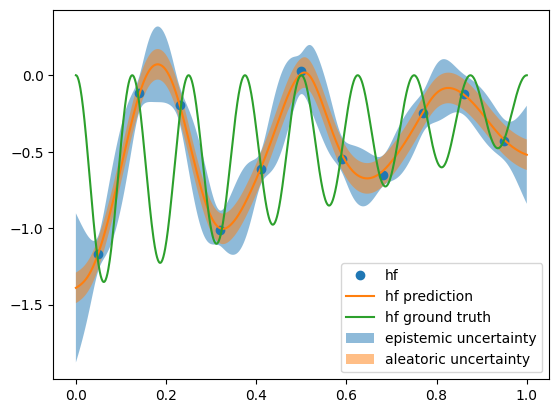

In [17]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    x=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")

plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# plt.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_total_unc).reshape(-1),
#     (bnn_y + 2 * bnn_total_unc).reshape(-1),
#     alpha=0.5,
#     label="uncertainty",
# )
# plot the episitmic uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_epistemic).reshape(-1),
    (bnn_y + 2 * bnn_epistemic).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)
# plot aleatoric uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_aleatoric).reshape(-1),
    (bnn_y + 2 * bnn_aleatoric).reshape(-1),
    alpha=0.5,
    label="aleatoric uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [18]:
# sequential mf-bnn
smf_bnn_lf1 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9555948972702026
epoch:  200 train loss:  0.954864501953125
epoch:  300 train loss:  0.9536898732185364
epoch:  400 train loss:  0.9486860632896423
epoch:  500 train loss:  0.8985247015953064
epoch:  600 train loss:  0.8151237368583679
epoch:  700 train loss:  0.7124153971672058
epoch:  800 train loss:  0.5420293211936951
epoch:  900 train loss:  0.3119969069957733
epoch:  1000 train loss:  0.046615004539489746
epoch:  1100 train loss:  0.016507625579833984
epoch:  1200 train loss:  0.009829522110521793
epoch:  1300 train loss:  0.00761041883379221
epoch:  1400 train loss:  0.006655679550021887
epoch:  1500 train loss:  0.006101361475884914
epoch:  1600 train loss:  0.005707493983209133
epoch:  1700 train loss:  0.0054054418578743935
epoch:  1800 train loss:  0.005168421193957329
epoch:  1900 train loss:  0.0049862186424434185
epoch:  2000 train loss:  0.004831599537283182
epoch:  2100 train loss:  0.004715063143521547

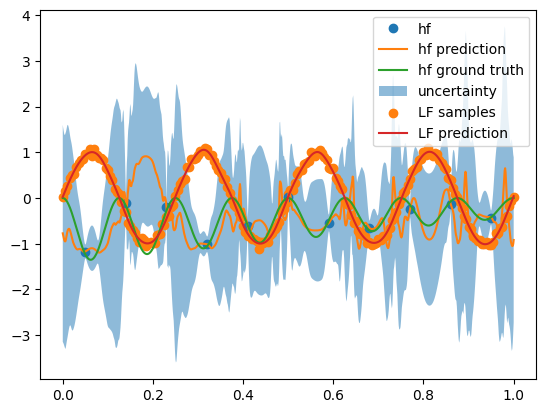

In [19]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(x=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [20]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="diff",
)
# define beta
mfdnnbnn_lf1.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9556723237037659
epoch:  200 train loss:  0.9553719162940979
epoch:  300 train loss:  0.9549621939659119
epoch:  400 train loss:  0.9532790780067444
epoch:  500 train loss:  0.9293494820594788
epoch:  600 train loss:  0.8527790307998657
epoch:  700 train loss:  0.794532835483551
epoch:  800 train loss:  0.7496370673179626
epoch:  900 train loss:  0.65462726354599
epoch:  1000 train loss:  0.5459820032119751
epoch:  1100 train loss:  0.411325603723526
epoch:  1200 train loss:  0.1184615045785904
epoch:  1300 train loss:  0.05577590689063072
epoch:  1400 train loss:  0.04804091528058052
epoch:  1500 train loss:  0.043855030089616776
epoch:  1600 train loss:  0.039333462715148926
epoch:  1700 train loss:  0.0335027351975441
epoch:  1800 train loss:  0.02664279192686081
epoch:  1900 train loss:  0.020172379910945892
epoch:  2000 train loss:  0.015347243286669254
epoch:  2100 train loss:  0.012041565030813217
epoch:  2200 t

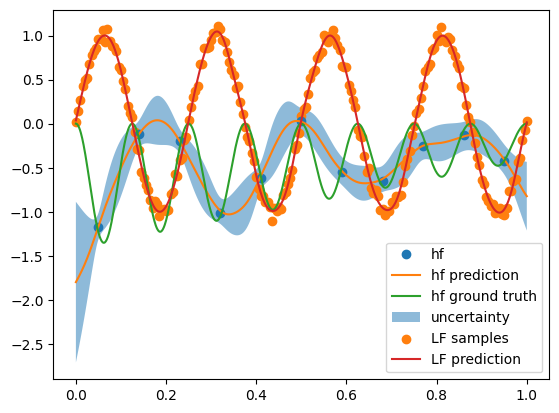

In [21]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(x=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()

In [22]:
# mf-dnn-bnn with different orders
mfdnnbnn_lf1_order_2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure={
        "in_features": 1,
        "hidden_features": [50, 50],
        "out_features": 1,
        "activation": "Tanh",
        "lr": 0.001,
        "sigma": 0.05,
    },
    beta_optimize=True,
    lf_order=2,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)

# train the model
mfdnnbnn_lf1_order_2.train(
    samples=samples,
    responses=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config={
        "num_epochs": 20000,
        "sample_freq": 100,
        "print_info": True,
        "burn_in_epochs": 10000,
    },
)

No data split: use all data for training
epoch:  100 train loss:  0.9556003212928772
epoch:  200 train loss:  0.9553857445716858
epoch:  300 train loss:  0.9550955891609192
epoch:  400 train loss:  0.9546753764152527
epoch:  500 train loss:  0.9539099335670471
epoch:  600 train loss:  0.951722264289856
epoch:  700 train loss:  0.9341942071914673
epoch:  800 train loss:  0.8783541917800903
epoch:  900 train loss:  0.7525767087936401
epoch:  1000 train loss:  0.5154041051864624
epoch:  1100 train loss:  0.23933576047420502
epoch:  1200 train loss:  0.046279702335596085
epoch:  1300 train loss:  0.03171804919838905
epoch:  1400 train loss:  0.024283111095428467
epoch:  1500 train loss:  0.01726502925157547
epoch:  1600 train loss:  0.01216387189924717
epoch:  1700 train loss:  0.0090627521276474
epoch:  1800 train loss:  0.007372040767222643
epoch:  1900 train loss:  0.006457124371081591
epoch:  2000 train loss:  0.005910816602408886
epoch:  2100 train loss:  0.005544941872358322
epoch:  

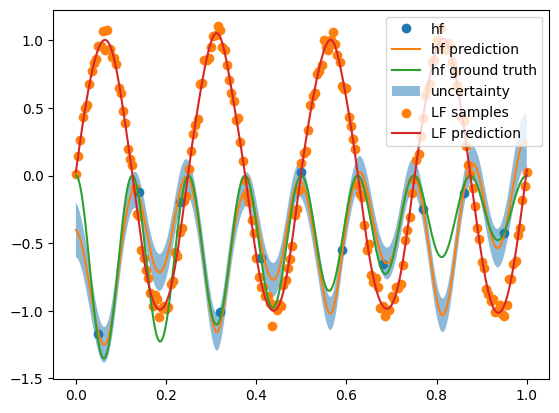

In [23]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_order_2_hy,
    mfdnnbnn_lf1_order_2_epistemic,
    mfdnnbnn_lf1_order_2_total_unc,
    mfdnnbnn_lf1_order_2_aleatoric,
) = mfdnnbnn_lf1_order_2.predict(x=test_samples)
# get lf predictions
mfdnnbnn_lf1_order_2_y = mfdnnbnn_lf1_order_2.predict_lf(
    x=test_samples, output_format="numpy")
mfdnnbnn_lf1_order_2_y_scale = (
    mfdnnbnn_lf1_order_2_y - hf_responses_mean)/hf_responses_std
transfered_ly = mfdnnbnn_lf1_order_2_y_scale**2 * \
    mfdnnbnn_lf1_order_2.beta[2] + mfdnnbnn_lf1_order_2_y_scale * \
    mfdnnbnn_lf1_order_2.beta[1] + mfdnnbnn_lf1_order_2.beta[0]

# hf_model predict
hf_y, _, _, _ = mfdnnbnn_lf1_order_2.hf_model.predict(x=test_samples)
# scale the prediction
hf_y = (transfered_ly+hf_y)*hf_responses_std + hf_responses_mean
# scale
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot transfered lf predictions
# ax.plot(test_samples.numpy(), transfered_ly,
#         label="Transfered LF prediction")
# plot hf predictions
# ax.plot(test_samples.numpy(), hf_y, label="HF prediction 111")
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(),
        mfdnnbnn_lf1_order_2_y,
        label="LF prediction")
ax.legend()
plt.show()

In [24]:
mfdnnbnn_lf1_order_2.beta

array([-0.03100568, -0.17772665, -0.84582408])

## mf models for the second dataset

In [25]:
# sequential mf-bnn
smf_bnn_lf2 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8565420508384705
epoch:  200 train loss:  0.8565008640289307
epoch:  300 train loss:  0.8564733862876892
epoch:  400 train loss:  0.8564492464065552
epoch:  500 train loss:  0.8564287424087524
epoch:  600 train loss:  0.8564116954803467
epoch:  700 train loss:  0.8563967347145081
epoch:  800 train loss:  0.856382429599762
epoch:  900 train loss:  0.8563674092292786
epoch:  1000 train loss:  0.8563504815101624
epoch:  1100 train loss:  0.8563297986984253
epoch:  1200 train loss:  0.8563024401664734
epoch:  1300 train loss:  0.8562626838684082
epoch:  1400 train loss:  0.8561931252479553
epoch:  1500 train loss:  0.8560466170310974
epoch:  1600 train loss:  0.8557455539703369
epoch:  1700 train loss:  0.8552804589271545
epoch:  1800 train loss:  0.8546183705329895
epoch:  1900 train loss:  0.8533044457435608
epoch:  2000 train loss:  0.8474656939506531
epoch:  2100 train loss:  0.8089266419410706
epoch:  2200 train loss:

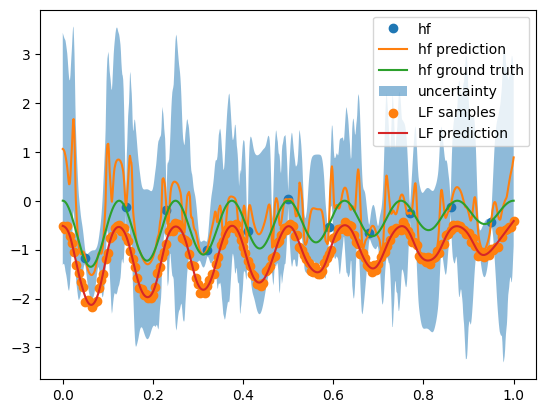

In [26]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf2_hy,
    smf_bnn_lf2_epistemic,
    smf_bnn_lf2_total_unc,
    smf_bnn_lf2_aleatoric,
) = smf_bnn_lf2.predict(x=test_samples)
# get lf predictions
smf_bnn_lf2_y = smf_bnn_lf2.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf2_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [27]:
# create the MFDNNBNN object
mfdnnbnn_lf2 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf2.train(
    samples=samples,
    responses=responses_lf2,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.8566481471061707
epoch:  200 train loss:  0.8565770387649536
epoch:  300 train loss:  0.8565162420272827
epoch:  400 train loss:  0.8564677238464355
epoch:  500 train loss:  0.856431245803833
epoch:  600 train loss:  0.856404185295105
epoch:  700 train loss:  0.8563825488090515
epoch:  800 train loss:  0.8563627004623413
epoch:  900 train loss:  0.8563418984413147
epoch:  1000 train loss:  0.8563176989555359
epoch:  1100 train loss:  0.8562877178192139
epoch:  1200 train loss:  0.85624760389328
epoch:  1300 train loss:  0.8561830520629883
epoch:  1400 train loss:  0.8559813499450684
epoch:  1500 train loss:  0.8538774847984314
epoch:  1600 train loss:  0.8362429141998291
epoch:  1700 train loss:  0.7655184268951416
epoch:  1800 train loss:  0.7029362916946411
epoch:  1900 train loss:  0.6710010766983032
epoch:  2000 train loss:  0.6105417013168335
epoch:  2100 train loss:  0.5399475693702698
epoch:  2200 train loss:  0

In [ ]:
(
    hy_proposed_lf2,
    epistemic_proposed_lf2,
    total_unc_proposed_lf2,
    aleatoric_proposed_lf2,
) = mfdnnbnn_lf2.predict(x=test_samples)
# lf prediction
lf2_y_proposed = mfdnnbnn_lf2.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf2, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf2_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf2_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

## for datset 3

In [ ]:
# sequential mf-bnn
smf_bnn_lf3 = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

In [ ]:
# plot
(
    smf_bnn_lf3_hy,
    smf_bnn_lf3_epistemic,
    smf_bnn_lf3_total_unc,
    smf_bnn_lf3_aleatoric,
) = smf_bnn_lf3.predict(x=test_samples)
# get lf predictions
smf_bnn_lf3_y = smf_bnn_lf3.predict_lf(x=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf3_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [ ]:
# create the MFDNNBNN object
mfdnnbnn_lf3 = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn_lf3.train(
    samples=samples,
    responses=responses_lf3,
    lf_train_config={
        "batch_size": None,
        "num_epochs": 50000,
        "print_iter": 100,
        "data_split": False,
    },
    hf_train_config=hf_train_config,
)

In [ ]:
# predict
(
    hy_proposed_lf3,
    epistemic_proposed_lf3,
    total_unc_proposed_lf3,
    aleatoric_proposed_lf3,
) = mfdnnbnn_lf3.predict(x=test_samples)
# lf prediction
lf3_y_proposed = mfdnnbnn_lf3.predict_lf(test_samples)

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), hy_proposed_lf3, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf3_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf3_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [ ]:
# print the beta values
print("Beta values")
print(mfdnnbnn_lf1.beta)
print(mfdnnbnn_lf1_order_2.beta)
print(mfdnnbnn_lf2.beta)
print(mfdnnbnn_lf3.beta)

In [ ]:
# evaluate the models on the accuracy metrics
# bnn model
# calculate the mse
import pandas as pd
bnn_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), bnn_y)
bnn_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), bnn_y, bnn_total_unc)
bnn_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), bnn_y)
# print the results
print("BNN model")
print(f"Normalized RMSE: {bnn_mse}")
print(f"Normalized MAE: {bnn_nmae}")
print(f"Normalized Log Likelihood: {bnn_nll}")
print(f"R2: {bnn_r2}")

# sequential mf-bnn on lf1
# calculate the mse
smf_bnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
smf_bnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy, smf_bnn_lf1_total_unc)
smf_bnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf1_hy)
# print the results
print("Sequential MF-BNN on LF1")
print(f"Normalized RMSE: {smf_bnn_lf1_mse}")
print(f"Normalized MAE: {smf_bnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf1_nll}")
print(f"R2: {smf_bnn_lf1_r2}")

# mf-dnn-bnn on lf1
# calculate the mse
mfdnnbnn_lf1_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
mfdnnbnn_lf1_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy, mfdnnbnn_lf1_total_unc)
mfdnnbnn_lf1_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_hy)
# print the results
print("MF-DNN-BNN on LF1")
print(f"Normalized RMSE: {mfdnnbnn_lf1_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_nll}")

# mf-dnn-bnn on lf1 with order 2
# calculate the mse
mfdnnbnn_lf1_order_2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
mfdnnbnn_lf1_order_2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy, mfdnnbnn_lf1_order_2_total_unc)
mfdnnbnn_lf1_order_2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), mfdnnbnn_lf1_order_2_hy)
# print the results
print("MF-DNN-BNN on LF1 with order 2")
print(f"Normalized RMSE: {mfdnnbnn_lf1_order_2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf1_order_2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf1_order_2_nll}")
print(f"R2: {mfdnnbnn_lf1_order_2_r2}")


# sequential mf-bnn on lf2
# calculate the mse
smf_bnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
smf_bnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy, smf_bnn_lf2_total_unc)
smf_bnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf2_hy)
# print the results
print("Sequential MF-BNN on LF2")
print(f"Normalized RMSE: {smf_bnn_lf2_mse}")
print(f"Normalized MAE: {smf_bnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf2_nll}")
print(f"R2: {smf_bnn_lf2_r2}")

# mf-dnn-bnn on lf2
# calculate the mse
mfdnnbnn_lf2_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
mfdnnbnn_lf2_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2, total_unc_proposed_lf2)
mfdnnbnn_lf2_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf2)
# print the results
print("MF-DNN-BNN on LF2")
print(f"Normalized RMSE: {mfdnnbnn_lf2_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf2_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf2_nll}")
print(f"R2: {mfdnnbnn_lf2_r2}")

# sequential mf-bnn on lf3
# calculate the mse
smf_bnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)
smf_bnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy, smf_bnn_lf3_total_unc)
smf_bnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), smf_bnn_lf3_hy)

# print the results
print("Sequential MF-BNN on LF3")
print(f"Normalized RMSE: {smf_bnn_lf3_mse}")
print(f"Normalized MAE: {smf_bnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {smf_bnn_lf3_nll}")
print(f"R2: {smf_bnn_lf3_r2}")

# mf-dnn-bnn on lf3
# calculate the mse
mfdnnbnn_lf3_mse = normalized_rmse(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nmae = normalized_mae(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
mfdnnbnn_lf3_nll = mean_log_likelihood_value(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3, total_unc_proposed_lf3)
mfdnnbnn_lf3_r2 = r2_score(
    test_hf_responses_noiseless.numpy(), hy_proposed_lf3)
# print the results
print("MF-DNN-BNN on LF3")
print(f"Normalized RMSE: {mfdnnbnn_lf3_mse}")
print(f"Normalized MAE: {mfdnnbnn_lf3_nmae}")
print(f"Normalized Log Likelihood: {mfdnnbnn_lf3_nll}")
print(f"R2: {mfdnnbnn_lf3_r2}")

# save the results in pandas dataframe
results = {
    "Model": ["BNN", "Sequential MF-BNN LF1", "MF-DNN-BNN LF1",
              "MF-DNN-BNN LF1 Order 2", "Sequential MF-BNN LF2",
              "MF-DNN-BNN LF2", "Sequential MF-BNN LF3", "MF-DNN-BNN LF3"],
    "Normalized RMSE": [bnn_mse, smf_bnn_lf1_mse, mfdnnbnn_lf1_mse,
                        mfdnnbnn_lf1_order_2_mse, smf_bnn_lf2_mse,
                        mfdnnbnn_lf2_mse, smf_bnn_lf3_mse, mfdnnbnn_lf3_mse],
    "Normalized MAE": [bnn_nmae, smf_bnn_lf1_nmae, mfdnnbnn_lf1_nmae,
                       mfdnnbnn_lf1_order_2_nmae, smf_bnn_lf2_nmae,
                       mfdnnbnn_lf2_nmae, smf_bnn_lf3_nmae, mfdnnbnn_lf3_nmae],
    "Normalized Log Likelihood": [bnn_nll, smf_bnn_lf1_nll, mfdnnbnn_lf1_nll,
                                  mfdnnbnn_lf1_order_2_nll, smf_bnn_lf2_nll,
                                  mfdnnbnn_lf2_nll, smf_bnn_lf3_nll, mfdnnbnn_lf3_nll],
    "R2": [bnn_r2, smf_bnn_lf1_r2, mfdnnbnn_lf1_r2,
           mfdnnbnn_lf1_order_2_r2, smf_bnn_lf2_r2,
           mfdnnbnn_lf2_r2, smf_bnn_lf3_r2, mfdnnbnn_lf3_r2],
}
results_df = pd.DataFrame(results)
print(results_df)
# save the results
results_df.to_csv("results.csv", index=False)

In [ ]:
results_df

In [ ]:
# plot the prediction of the models into one figure where the first row is the
# prediction of bnn (with one subfigure), and the second row is the prediction of sequential mf-bnn mf-dnn-bnn on lf1 (with two subfigures)
# the third row is the prediction of sequential mf-bnn mf-dnn-bnn on lf2 (with two subfigures)
# the forth row is the prediction of sequential mf-bnn mf-dnn-bnn on lf3  (with two subfigures)
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
# plot the prediction of bnn
axs[0, 0].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10, label="HF samples")
axs[0, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[0, 0].plot(test_samples.numpy(),
               bnn_y,
               "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)

axs[0, 0].fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[0, 0].legend()
axs[0, 0].set_title("BNN")

# plot the prediction of mf-dnn-bnn on lf1 with order1
axs[0, 1].plot(hf_samples, hf_responses, "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[0, 1].plot(lf_samples, lf1_responses,
               "+", color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[0, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# plot the lf truth
axs[0, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[0, 1].plot(test_samples.numpy(),
               mfdnnbnn_lf1_hy,  "-",
               color="#CC3311",
               linewidth=2,
               label="HF prediction",)
axs[0, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_order_2_y,
    "-", color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
axs[0, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[0, 1].legend()
axs[0, 1].set_title(r"DNN-LR$^1$-BNN (LF data 1)")


# plot the prediction of sequential mf-bnn on lf1
axs[1, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[1, 0].plot(lf_samples, lf1_responses,  '+',
               color="#AA4499",
               linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples",)
axs[1, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[1, 0].plot(test_samples.numpy(), smf_bnn_lf1_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[1, 0].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
#
axs[1, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,

    label="LF prediction"
)
axs[1, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 0].legend()
axs[1, 0].set_title("DNN-BNN (LF data 1)")


# plot the prediction of mf-dnn-bnn on lf1
axs[1, 1].plot(hf_samples, hf_responses, "kx",
               linewidth=2,
               markersize=10,
               label="HF samples")
axs[1, 1].plot(lf_samples, lf1_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[1, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
# with lf order 2
axs[1, 1].plot(test_samples.numpy(), mfdnnbnn_lf1_order_2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[1, 1].plot(
    test_samples.numpy(),
    test_lf1_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[1, 1].plot(
    test_samples.numpy(),
    mfdnnbnn_lf1_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# with lf order 2
axs[1, 1].fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_order_2_hy - 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    (mfdnnbnn_lf1_order_2_hy + 2 * mfdnnbnn_lf1_order_2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

# axs[1, 1].legend()
axs[1, 1].set_title(r"DNN-LR$^2$-BNN (LF data 1)")
# plot the prediction of sequential mf-bnn on lf2
axs[2, 0].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples",)
axs[2, 0].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)


axs[2, 0].plot(test_samples.numpy(), smf_bnn_lf2_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction",)
# plot the lf truth
axs[2, 0].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[2, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf2_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[2, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf2_hy - 2 * smf_bnn_lf2_total_unc).reshape(-1),
    (smf_bnn_lf2_hy + 2 * smf_bnn_lf2_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[2, 0].legend()
axs[2, 0].set_title("DNN-BNN (LF data 2)")

# plot the prediction of mf-dnn-bnn on lf2
axs[2, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[2, 1].plot(lf_samples, lf2_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[2, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)

axs[2, 1].plot(test_samples.numpy(), hy_proposed_lf2,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")
# plot the lf truth
axs[2, 1].plot(
    test_samples.numpy(),
    test_lf2_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
# plot the lf prediction
axs[2, 1].plot(
    test_samples.numpy(),
    lf2_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
# plot the uncertainty
axs[2, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf2 - 2 * total_unc_proposed_lf2).reshape(-1),
    (hy_proposed_lf2 + 2 * total_unc_proposed_lf2).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval"
)

# axs[2, 1].legend()
axs[2, 1].set_title("DNN-LR-BNN (LF data 2)")
# plot the prediction of sequential mf-bnn on lf3
axs[3, 0].plot(hf_samples, hf_responses,
               'kx', linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 0].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 0].plot(test_samples.numpy(), smf_bnn_lf3_hy,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")

# plot the lf truth
axs[3, 0].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)

axs[3, 0].plot(
    test_samples.numpy(),
    smf_bnn_lf3_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"

)

axs[3, 0].fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf3_hy - 2 * smf_bnn_lf3_total_unc).reshape(-1),
    (smf_bnn_lf3_hy + 2 * smf_bnn_lf3_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# axs[3, 0].legend()
axs[3, 0].set_title("DNN-BNN (LF data 3)")

# plot the prediction of mf-dnn-bnn on lf3
axs[3, 1].plot(hf_samples, hf_responses,
               "kx", linewidth=2,
               markersize=10,
               label="HF samples")
axs[3, 1].plot(lf_samples, lf3_responses,
               '+', color="#AA4499", linewidth=2,
               markersize=10,
               alpha=0.5,
               label="LF samples")
axs[3, 1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
axs[3, 1].plot(test_samples.numpy(), hy_proposed_lf3,
               "-", color="#CC3311",
               linewidth=2,
               label="HF prediction")


# plot the lf truth
axs[3, 1].plot(
    test_samples.numpy(),
    test_lf3_responses_noiseless.numpy(),
    "--", color="#EE7733",
    linewidth=2,
    label="LF truth",
)
axs[3, 1].plot(
    test_samples.numpy(),
    lf3_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction"
)
axs[3, 1].fill_between(
    test_samples.flatten().numpy(),
    (hy_proposed_lf3 - 2 * total_unc_proposed_lf3).reshape(-1),
    (hy_proposed_lf3 + 2 * total_unc_proposed_lf3).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",

)
# axs[3, 1].legend()
axs[3, 1].set_title("DNN-LR-BNN (LF data 3)")
# set the axis labels x for the bottom row and y for the left column
for ii in range(4):
    for jj in range(2):
        if ii == 3:
            axs[ii, jj].set_xlabel("x", fontsize=12)
        if jj == 0:
            axs[ii, jj].set_ylabel("y", fontsize=12)
# set the line width of the axes
for ii in range(4):
    for jj in range(2):
        axs[ii, jj].spines["top"].set_linewidth(1.5)
        axs[ii, jj].spines["right"].set_linewidth(1.5)
        axs[ii, jj].spines["left"].set_linewidth(1.5)
        axs[ii, jj].spines["bottom"].set_linewidth(1.5)
        # font size of the axis
        axs[ii, jj].tick_params(axis="both", which="major", labelsize=12)

# set the limit of y for each row

for jj in range(2):
    axs[0, jj].set_ylim([-1.75, 1.75])
    axs[1, jj].set_ylim([-2, 2])
    axs[2, jj].set_ylim([-2.5, 0.75])
    axs[3, jj].set_ylim([-2, 1.5])
# set legende for the first subfigure  and put it outside the figure
axs[0, 1].legend(loc='upper left', bbox_to_anchor=(-1.2, 1.4), fontsize=10,
                 frameon=True, ncol=7)

# add beta values to the right subfigures
axs[0, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf1.beta[0].item(), mfdnnbnn_lf1.beta[1].item()),
    fontsize=12,
    transform=axs[0, 1].transAxes)
axs[1, 1].text(0.45, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f} $\hat \rho_2$={:0.2f}" .format(
    mfdnnbnn_lf1_order_2.beta[0].item(), mfdnnbnn_lf1_order_2.beta[1].item(), mfdnnbnn_lf1_order_2.beta[2].item()),
    fontsize=12,
    transform=axs[1, 1].transAxes)
axs[2, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf2.beta[0].item(), mfdnnbnn_lf2.beta[1].item()),
    fontsize=12,
    transform=axs[2, 1].transAxes)
axs[3, 1].text(0.6, 0.05, r"$ \hat \rho_0$ ={:0.2f} $\hat \rho_1$={:0.2f}" .format(
    mfdnnbnn_lf3.beta[0].item(), mfdnnbnn_lf3.beta[1].item()),
    fontsize=12,
    transform=axs[3, 1].transAxes)

# space of sub-figures
plt.subplots_adjust(wspace=0.1, hspace=0.4)
# save
plt.savefig("mf_dnn_bnn_known_noise.pdf", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.png", bbox_inches="tight", dpi=300)
plt.savefig("mf_dnn_bnn_known_noise.svg", bbox_inches="tight", dpi=300)
plt.show()